<a href="https://colab.research.google.com/github/Nioron07/Bill-Prediction-model/blob/main/bill_prediction_models.py" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
from dateutil import parser
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/ML_Project/bills_data.csv")
print(df.shape)
df.drop_duplicates()
print(df.shape)
#One hot encodes whether a law has passed or not 1=passed 0 = not passed
df.loc[df['Latest Action'].str.contains('Public Law'), 'Latest Action']=1
df.loc[df['Latest Action']!=1, 'Latest Action']=0

#One hot encodes the sponsor column by party R = 1 D = 0
df.loc[df['Sponsor'].str.contains('Rep.-R', na=False), 'Sponsor']=1
df.loc[df['Sponsor'].str.contains('Sen.-R', na=False), 'Sponsor']=1
df.loc[df['Sponsor']!=1, 'Sponsor']=0

# #One hot encodes where the bill came from 0 = House 1 = Senate
df.loc[df['Legislation Number'].str.contains('H.R.'), "Legislation Number"]=0
df.loc[df['Legislation Number']!=0, 'Legislation Number']=1
df.rename(columns = {'Legislation Number':'House_Or_Senate', 'Sponsor':'Sponsor_Party'}, inplace=True)

df['Number of Related Bills'] = df['Number of Related Bills'].fillna(0)
df['Number of Cosponsors'] = df['Number of Cosponsors'].fillna(0)
df['Committees'] = df['Committees'].fillna('No Committe')
#creates new column to represent the number of days a bill has been in congress for
df.insert(0, 'Days Of Consideration',[None]*len(df['Congress']))

#Calculates num of days in between the introduction date and the last action date and inputs that number into days of consideration
for i in range(len(df['Date of Introduction'])):
  date1 = parser.parse(df['Date of Introduction'][i], yearfirst = None)
  date2 = parser.parse(df['Latest Action Date'][i], yearfirst = None)
  delta = date2-date1
  df['Days Of Consideration'][i] = delta.days

df.drop(columns = ['Date of Introduction', 'Latest Action Date'], inplace=True)

# #Keeps just the number of the congress in each element for the Congress row
df['Congress'] = df['Congress'].apply(lambda x: x[:3] if len(x) == 26 else x[:2])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(135000, 10)
(135000, 10)


<ipython-input-1-db08cbf00131>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Days Of Consideration'][i] = delta.days


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

documents = df['Title']

#Converts text to numbers
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

#Defines clusters and fits kmeans model to vectorized text
true_k = 32
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

#changes every cell to the cluster that text is in
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
def Predict_On_Title(text):
  Y = vectorizer.transform([text])
  prediction = model.predict(Y)
  return prediction[0]
df['Title'] = df['Title'].apply(Predict_On_Title)


Top terms per cluster:


In [ ]:
documents = df['Committees']

#Converts text to numbers
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

#Defines clusters and fits kmeans model to vectorized text
true_k = 37
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

#changes every cell to the cluster that text is in
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
def Predict_On_Committee(text):
  Y = vectorizer.transform([text])
  prediction = model.predict(Y)
  return prediction[0]
df['Committees'] = df['Committees'].apply(Predict_On_Committee)

Top terms per cluster:


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#Defines Independent and Dependent variables
X = df.drop(columns='Latest Action')
y = df['Latest Action']

#Splits data and SMOTE's training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
y_train=y_train.astype('int')
smt = SMOTE(random_state = 0)
X_train, y_train = smt.fit_resample(X_train, y_train)

NameError: ignored

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

#Creates callable fucntion to allow for cross validation of all relevent stats
def Cross_Validate_Classifier(clf):
    scoring = {'f1_macro':'f1_macro',
           'accuracy':'accuracy',
           'precision_macro':'precision_macro',
           'recall_macro':'recall_macro',
           'brier_score_loss':make_scorer(brier_score_loss)}

    k = 10

    cv_results = cross_validate(clf, X_train, y_train, cv = k, scoring = scoring)
    import statistics as s
#formats and prints relevent stats
    brier_avg = cv_results['test_brier_score_loss'].mean()
    brier_stv = s.stdev(cv_results['test_brier_score_loss'])
    f1_avg = cv_results['test_f1_macro'].mean()
    f1_stv = s.stdev(cv_results['test_f1_macro'])
    acc_avg = cv_results['test_accuracy'].mean()
    acc_stv = s.stdev(cv_results['test_accuracy'])
    prec_avg = cv_results['test_precision_macro'].mean()
    prec_stv = s.stdev(cv_results['test_precision_macro'])
    rec_avg = cv_results['test_recall_macro'].mean()
    rec_stv = s.stdev(cv_results['test_recall_macro'])
    print(f'The average brier-score is {round(brier_avg, 3)}, the standard deviation is {round(brier_stv, 3)}')
    print(f'The average f1-score is {round(f1_avg, 3)}, the standard deviation is {round(f1_stv, 3)}')
    print(f'The average accuracy is {round(acc_avg, 3)}, the standard deviation is {round(acc_stv, 3)}')
    print(f'The average precision is {round(prec_avg, 3)}, the standard deviation is {round(prec_stv, 3)}')
    print(f'The average recall is {round(rec_avg, 3)}, the standard deviation is {round(rec_stv, 3)}')


In [ ]:
from sklearn import metrics
y_test = y_test.astype(int)
#Creates callable fucntion to allow for easy plotting of AUROC curve
def Plot_AUROC_Curve(pred, clf):
  fpr, tpr, thresholds = metrics.roc_curve(y_test, pred) #take a look at these!
  roc_auc = metrics.auc(fpr, tpr)

  # plot AUROC using values
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=type(clf)) #check the type - matplotlib!!
  display.plot()
  plt.show()

DECISION TREE, GAUSSIANNB, AND ADABOOST

In [ ]:
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

In [ ]:
#Decision Tree
dtc_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=140)
dtc_clf.fit(X_train, y_train)
dtc_pred = dtc_clf.predict(X_test)

In [ ]:
Cross_Validate_Classifier(dtc_clf)

The average brier-score is 0.031, the standard deviation is 0.029
The average f1-score is 0.969, the standard deviation is 0.029
The average accuracy is 0.969, the standard deviation is 0.029
The average precision is 0.971, the standard deviation is 0.025
The average recall is 0.969, the standard deviation is 0.029


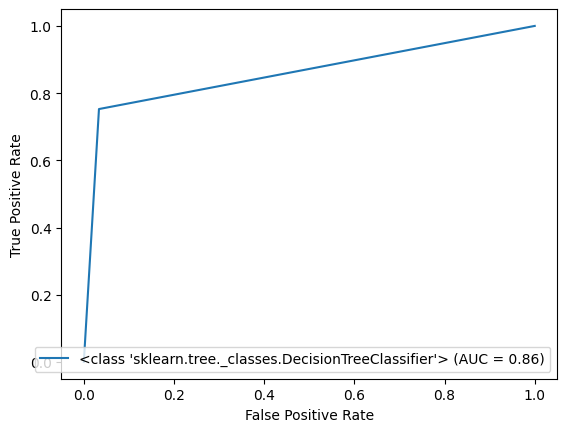

In [ ]:
Plot_AUROC_Curve(dtc_pred, dtc_clf)

In [ ]:
#GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
gnb_pred = dtc_clf.predict(X_test)

In [ ]:
Cross_Validate_Classifier(gnb_clf)

The average brier-score is 0.268, the standard deviation is 0.004
The average f1-score is 0.722, the standard deviation is 0.005
The average accuracy is 0.732, the standard deviation is 0.004
The average precision is 0.774, the standard deviation is 0.004
The average recall is 0.732, the standard deviation is 0.004


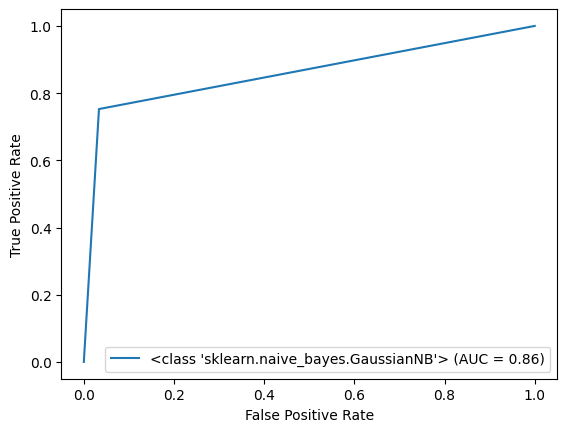

In [ ]:
Plot_AUROC_Curve(gnb_pred, gnb_clf)

ADABOOST CODE

In [ ]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
adaclf = AdaBoostClassifier(base_estimator=dtc_clf, #You can run this line with either DTC or GNB or any classi
                            n_estimators=50,
                            learning_rate=0.5,
                            random_state=24)
adaclf.fit(X_train,y_train)
adaclf_pred = adaclf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
Cross_Validate_Classifier(adaclf)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

The average brier-score is 0.026, the standard deviation is 0.029
The average f1-score is 0.974, the standard deviation is 0.03
The average accuracy is 0.974, the standard deviation is 0.029
The average precision is 0.976, the standard deviation is 0.025
The average recall is 0.974, the standard deviation is 0.029


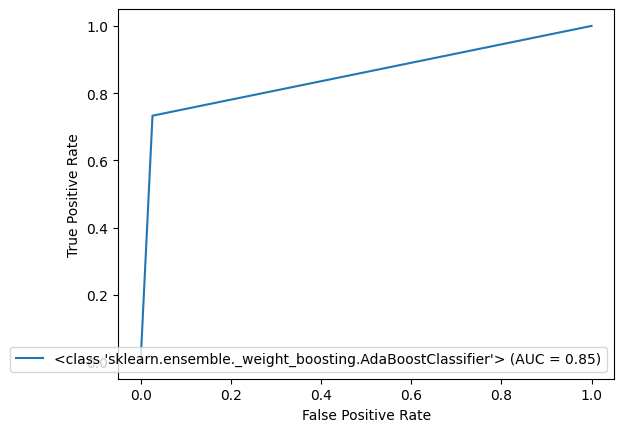

In [ ]:
Plot_AUROC_Curve(adaclf_pred, adaclf)

NEURAL NETWORK

In [ ]:
# Importing tools
from tensorflow import keras
from keras import layers
from keras import initializers

#weight initializer
initializer = keras.initializers.LecunNormal()

#Create NN model
nn = keras.Sequential(
    [
        keras.Input(shape=(8)),
        layers.Dense(8,activation="tanh", kernel_initializer = initializer),
        layers.Dense(8,activation="tanh"),
        layers.Dense(8,activation="tanh"),
        layers.Dense(8,activation="tanh"),
        layers.Dense(8,activation="tanh"),
        layers.Dense(8,activation="tanh"),
        layers.Dense(8,activation="tanh"),
        layers.Dense(8,activation="tanh"),
        layers.Dense(8,activation="tanh"),
        layers.Dense(1,activation="relu"),
    ]
)

#measure losses, metrics, and optimizing
nn.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-3),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [keras.metrics.BinaryAccuracy(),
               keras.metrics.AUC(),
              ],
)

# #fit and perdict
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
nn_history = nn.fit(X_train,y_train, epochs=50)

pred_nn = nn.predict(X_test)

Epoch 1/50
6256/6256 [==============================] - 22s 3ms/step - loss: 0.4558 - binary_accuracy: 0.8083 - auc: 0.8737
Epoch 2/50
6256/6256 [==============================] - 17s 3ms/step - loss: 0.4140 - binary_accuracy: 0.8180 - auc: 0.8876
Epoch 3/50
6256/6256 [==============================] - 17s 3ms/step - loss: 0.3949 - binary_accuracy: 0.8302 - auc: 0.8966
Epoch 4/50
6256/6256 [==============================] - 17s 3ms/step - loss: 0.3741 - binary_accuracy: 0.8480 - auc: 0.9070
Epoch 5/50
6256/6256 [==============================] - 18s 3ms/step - loss: 0.3661 - binary_accuracy: 0.8471 - auc: 0.9143
Epoch 6/50
6256/6256 [==============================] - 18s 3ms/step - loss: 0.3538 - binary_accuracy: 0.8501 - auc: 0.9181
Epoch 7/50
6256/6256 [==============================] - 17s 3ms/step - loss: 0.3495 - binary_accuracy: 0.8511 - auc: 0.9215
Epoch 8/50
6256/6256 [==============================] - 17s 3ms/step - loss: 0.3525 - binary_accuracy: 0.8503 - auc: 0.9213
Epoch 9/

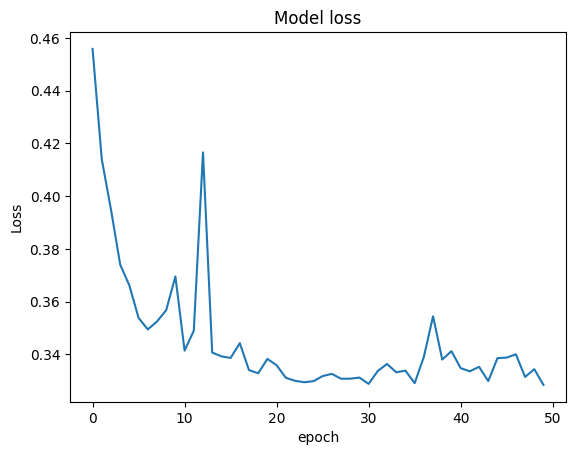

In [ ]:
#Visualize loss function
plt.plot(nn_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

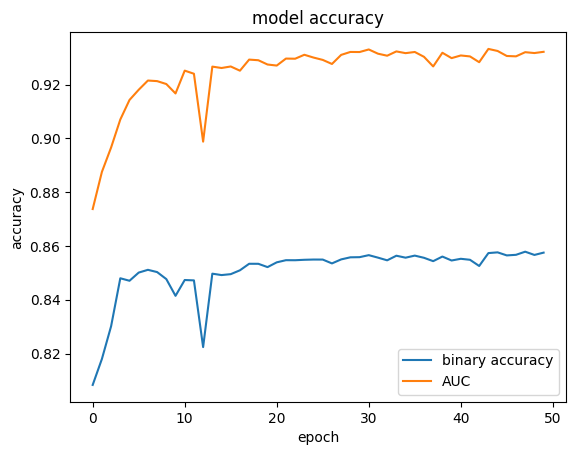

In [ ]:
#Visulaize Metrics
plt.plot(nn_history.history['binary_accuracy'])
plt.plot(nn_history.history['auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["binary accuracy","AUC"])
plt.show()

LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0).fit(X_train, y_train)
pred = LR.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
Cross_Validate_Classifier(LR)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

The average brier-score is 0.174, the standard deviation is 0.002
The average f1-score is 0.826, the standard deviation is 0.002
The average accuracy is 0.826, the standard deviation is 0.002
The average precision is 0.829, the standard deviation is 0.002
The average recall is 0.826, the standard deviation is 0.002


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


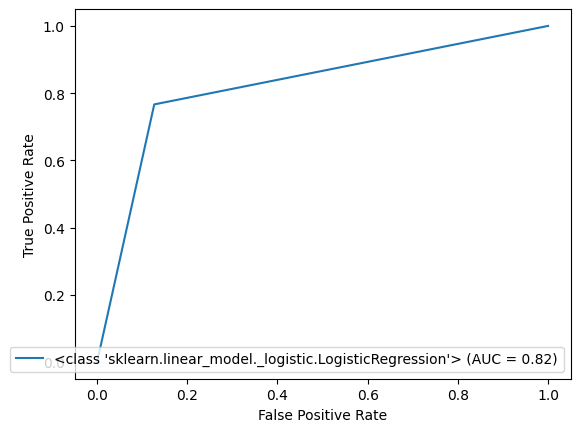

In [ ]:
Plot_AUROC_Curve(pred, LR)

GRADIENT BOOSTER

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
grd = HistGradientBoostingClassifier(learning_rate=0.5, max_depth=5, random_state=0).fit(X_train, y_train)
pred = grd.predict(X_test)

In [ ]:
Cross_Validate_Classifier(grd)

The average brier-score is 0.041, the standard deviation is 0.041
The average f1-score is 0.959, the standard deviation is 0.042
The average accuracy is 0.959, the standard deviation is 0.041
The average precision is 0.962, the standard deviation is 0.032
The average recall is 0.959, the standard deviation is 0.041


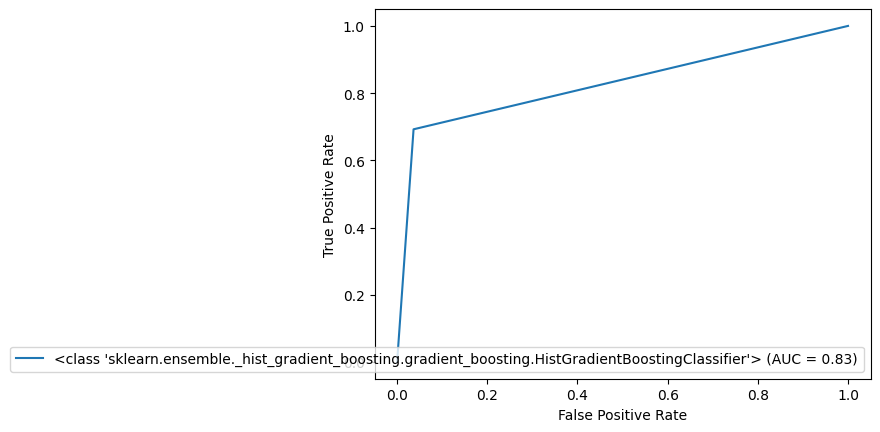

In [ ]:
Plot_AUROC_Curve(pred, grd)

RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC.fit(X_train,y_train) #fitting estimator
pred=RFC.predict(X_test)


In [ ]:
Cross_Validate_Classifier(RFC)

The average brier-score is 0.018, the standard deviation is 0.027
The average f1-score is 0.982, the standard deviation is 0.028
The average accuracy is 0.982, the standard deviation is 0.027
The average precision is 0.983, the standard deviation is 0.023
The average recall is 0.982, the standard deviation is 0.027


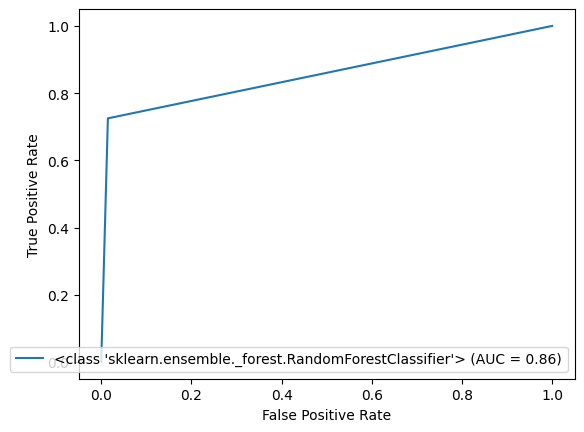

In [ ]:
Plot_AUROC_Curve(pred, RFC)

VOTING CLASSIFIER

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# group / ensemble of models
estimator = []
estimator.append(('Adaboost DTC', adaclf))
estimator.append(('Gradient Boost', grd))
estimator.append(('Random Forest Classifier', RFC))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
vot_hard_pred = vot_hard.predict(X_test)

# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, y_train)
vot_soft_pred = vot_soft.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
Cross_Validate_Classifier(vot_hard)
Cross_Validate_Classifier(vot_soft)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

The average brier-score is 0.02, the standard deviation is 0.03
The average f1-score is 0.98, the standard deviation is 0.03
The average accuracy is 0.98, the standard deviation is 0.03
The average precision is 0.982, the standard deviation is 0.025
The average recall is 0.98, the standard deviation is 0.03


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

The average brier-score is 0.021, the standard deviation is 0.03
The average f1-score is 0.979, the standard deviation is 0.03
The average accuracy is 0.979, the standard deviation is 0.03
The average precision is 0.98, the standard deviation is 0.025
The average recall is 0.979, the standard deviation is 0.03


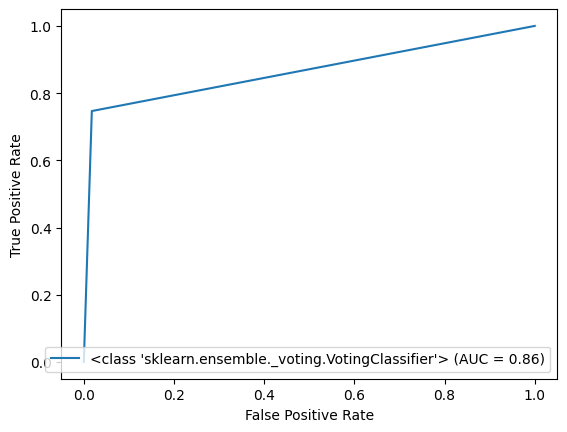

In [ ]:
Plot_AUROC_Curve(vot_hard_pred, vot_hard)

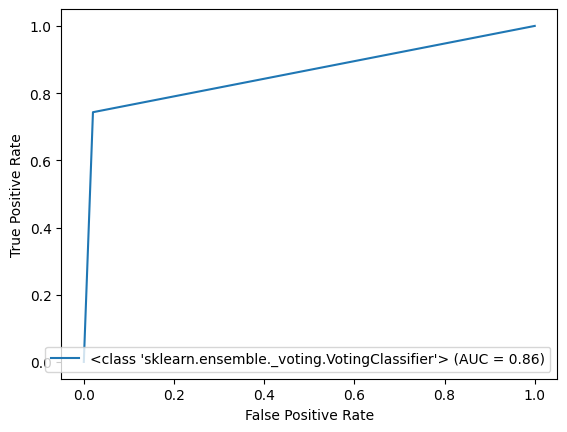

In [ ]:
Plot_AUROC_Curve(vot_soft_pred, vot_soft)